In [1]:
import Su22
import qiskit as qk
import numpy as np
from qiskit.tools.visualization import plot_histogram
from qiskit import IBMQ
from qiskit.tools.monitor import job_monitor
from qiskit.providers.aer.noise import NoiseModel
import matplotlib
import matplotlib.pyplot as plt
from qiskit.visualization import plot_bloch_multivector
from qiskit.tools.monitor import job_monitor

from qiskit import pulse              
from qiskit.circuit import Parameter 
from IPython.display import display
from qiskit import QuantumCircuit
from qiskit.circuit import Gate
import warnings
warnings.filterwarnings('ignore')
from qiskit.tools.jupyter import *
# The pulse simulator
from qiskit.providers.aer import PulseSimulator

# Object for representing physical models
from qiskit.providers.aer.pulse import PulseSystemModel
token = '792003cde0750f1452faa5cb5fe7c57da849e1119983f608e9a359d49cdb396391d6af09eedfb46af0a043a01103ed64da66835d1a318c0013d64ab3ebc1fe61'
qk.IBMQ.save_account(token=token)
qk.IBMQ.enable_account(token)
provider = IBMQ.get_provider(hub='ibm-q-ornl', group='ornl', project='phy147')
#backend = provider.get_backend("ibmq_jakarta")
from qiskit.test.mock import FakeJakarta

configrc.store_credentials:WARNING:2023-03-19 20:39:26,062: Credentials already present. Set overwrite=True to overwrite.


In [2]:
backend = provider.get_backend("ibmq_guadalupe")
backend = FakeJakarta()

In [8]:
print(backend.configuration().dt)

2.2222222222222221e-10


##  Established functions

In [10]:
import pickle
import numpy as np
def loadData(inp):
    # for reading also binary mode is important
    dbfile = open(inp, 'rb')     
    db = pickle.load(dbfile)
    dbfile.close()
    return db

In [11]:
x= [np.cos(i)**2 for i in range(128)]

In [ ]:
x

In [13]:
dbfile = open("cos^2.p", 'wb') 
pickle.dump(x,dbfile)
dbfile.close()

In [4]:
from qiskit import QuantumRegister, QuantumCircuit, ClassicalRegister, Aer
from qiskit.quantum_info import state_fidelity
from qiskit.providers.aer import noise

# Tomography functions
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
import qiskit.ignis.mitigation.measurement as mc
import time

def Full_tomography(circ, backend):
    t = time.time()
    test_circ = state_tomography_circuits(circ,[0])
    job = qk.execute(test_circ, backend=backend, shots=8192)
    test_state = StateTomographyFitter(job.result(), test_circ).fit()
    print('Tomography Time taken:', time.time() - t)
    return test_state

def State_Fidel(circ, backend):
    #actual state calculation
    q2 = QuantumRegister(1)
    state = QuantumCircuit(q2)
    state.x(q2[0])
    job = qk.execute(state, backend=Aer.get_backend('statevector_simulator'))
    state_results = job.result().get_statevector(state)
    test_state = Full_tomography(circ,backend)
    t = time.time()
    Fidelity = state_fidelity(state_results,test_state)
    print('Fidelity Fitting Time taken:', time.time() - t)
    return Fidelity

def plot_m(state):
    return 0

In [15]:
import numpy as np
import scipy.signal as si
import scipy.linalg as la
import matplotlib.pyplot as plt
import qiskit as qk
from qiskit import Aer
from qiskit.providers.ibmq.managed import IBMQJobManager
from qiskit.visualization.pulse_v2 import device_info, stylesheet
from qiskit.visualization.pulse_v2.events import ChannelEvents
from qiskit.visualization.pulse_v2.generators import gen_filled_waveform_stepwise
import  qiskit.pulse.transforms.canonicalization as canon
from joblib import Parallel, delayed
import os

cpu_count = 10
noise_power = 1e-3
num_noise_trajs = 30

def generate_noise_params(s_pow, w0):
    a = [1]
    NN = 512
    BW = 0.005 # changes narrowness of noise spectrum
    b = si.firwin(NN, BW)*np.cos(w0*np.pi*np.arange(NN))
    b = b/la.norm(b)*np.sqrt(s_pow)
    return a, b

def parametrize_circ(circ,noise_traj_list,backend):
    par = qk.circuit.ParameterVector('thetha', length=int(len(circ)/64))
    batch = []
    for traj in noise_traj_list:
        with pulse.build(backend=backend,default_alignment='sequential') as temp:
            for j in range(int(len(circ)/64)):
                pulse.play(circ[j*64:(j+1)*64], pulse.drive_channel(0))
                pulse.shift_phase(par[j],pulse.drive_channel(0))
            pulse.measure(qubits=[0], registers=[pulse.MemorySlot(0)])
        for i in range(len(par)):
            temp.assign_parameters({par[i]: traj[i]}, inplace=True)
        batch.append(temp)
    return batch

def shift_all(circ, traj):
    final = []
    start = 0
    for j,i in enumerate(circ):
        final.append((np.cos(start) + 1j*np.sin(start))*i)
        start+=traj[j]
    return final
        
def parametrize_circ_1(circ,noise_traj_list,backend):
    par = qk.circuit.ParameterVector('thetha', length=int(len(circ)))
    batch = []
    for traj in noise_traj_list:
        with pulse.build(backend=backend,default_alignment='sequential') as temp:
            pulse.play(shift_all(circ,traj), pulse.drive_channel(0))
            pulse.measure(qubits=[0], registers=[pulse.MemorySlot(0)])
        batch.append(temp)
    return batch

def schwarma_trajectories(a, b, num_gates, num_trajectories):
    # a: coefficients of linear filter numerator
    # b: coefficients of linear filter demoninator
    # num_gates: number of gates in circuit to be "schwarmafied"
    # num_trajectories: number of noise trajectories required
    traj_list = []
    for _ in range(num_trajectories):
        angles = si.lfilter(b, a, np.random.randn(num_gates + 1000))[1000:]
        traj_list.append(angles)
    return traj_list

shots=1000
def runfunc(circ,backend_sim):
    rabi_qobj = assemble(circ, 
                     backend=backend_sim,
                     meas_level=2, 
                     shots=100)
    results = backend_sim.run(rabi_qobj).result()
    return results


from qiskit.providers.aer.pulse import PulseSystemModel
from qiskit.providers.aer import PulseSimulator
from qiskit.compiler import assemble
def Spec(data,start,end,num_center_freqs=100,backend=backend, option = 0):  
    #option 0 beaks upp pulse into 64dt chuncks option 1 will morph shift into pulse
    if(option):
        num_gates=int(len(data))
    else:
        num_gates=int(len(data)/64)
    circ_batch = []
    center_idxs=[]
    centers=[]
    all_probs = np.zeros([num_center_freqs, 2])
    for center_idx, center in enumerate(np.linspace(start, end, num_center_freqs)): # vary noise center frequency
        center_idxs.append(center_idx)
        centers.append(center)
        #print('Probing Filter Function at Normalized Frequency: ', center)
        # Generate noise trajectories
        a, b = generate_noise_params(noise_power, center)
        noise_traj_list = np.array(schwarma_trajectories(a, b, num_gates, num_noise_trajs))
    
        # Build noisy circuit dictionary
        if(not option):
            circ_batch+=(parametrize_circ(data,noise_traj_list,backend))
        else:
            circ_batch+=(parametrize_circ_1(data,noise_traj_list,backend))

    # Run circuits
    armonk_model = PulseSystemModel.from_backend(backend)
    backend_sim = PulseSimulator(system_model=armonk_model)
    results = Parallel(n_jobs=cpu_count)(delayed(runfunc)(i,backend_sim) for i in circ_batch)
    '''job_manager = IBMQJobManager()
    job_set = job_manager.run(circ_batch, backend=backend, shots = shots, name=('Spectrosopy'+str(time.strftime("%H:%M:%S", time.localtime()))))
    results = job_set.results()'''
    
    # Compile Results
    cc=0
    prob = 0
    counter = 0
    for i in range(int(len(circ_batch)/num_noise_trajs)):
        for circ in circ_batch[i*num_noise_trajs:((i+1)*num_noise_trajs)]:
            zero_counts = results.get_counts(cc).get('1')
            prob += zero_counts/shots
            cc+=1
        prob = prob/num_noise_trajs
        all_probs[int(center_idxs[counter]), :] = centers[counter], prob
        counter+=1
        prob=0
    
    return all_probs, circ_batch


## New func

In [6]:
from matplotlib import animation
import random
from qiskit.circuit import Gate
from qiskit.visualization import visualize_transition
from mpl_toolkits.mplot3d import Axes3D
from qiskit.visualization.bloch import Bloch
from IPython.display import HTML
from qiskit.visualization import plot_bloch_vector
from qiskit import transpile, schedule as build_schedule
import qiskit.result.result as resultifier

def our_tomography_circuits(circ,counter):
    cz = qk.QuantumCircuit(1,1,name ="('Z',)")
    cz.compose(circ,[0],inplace= True)
    cz.measure(0,0)
    cy =qk.QuantumCircuit(1,1,name ="('Y',)")
    cy.compose(circ,[0],inplace= True)
    cy.sdg(0)
    cy.h(0)
    cy.measure(0,0)
    cx = qk.QuantumCircuit(1,1,name ="('X',)")
    cx.compose(circ,[0],inplace= True)
    cx.h(0)
    cx.measure(0,0)
    return transpile([cx,cy,cz],backend)

def full_tom(data,backend):
    states_circs= []
    states_pulse= []
    result_states =[]
    DM_states =[]
    temp= [0 for i in range(63)]
    '''qc = qk.QuantumCircuit(1)
    qc.h(0)
    tran_qc= transpile(qc, backend)
    h_pulse_sched= build_schedule(tran_qc,backend)
    qc = qk.QuantumCircuit(1)
    qc.sdg(0)
    tran_qc= transpile(qc, backend)
    sqg_pulse_sched= build_schedule(tran_qc,backend)'''
    #circ = qk.QuantumCircuit(1,1)
    #custom_gate = Gate("temp", 1, [])
    #circ.append(custom_gate, [0])
    counter = 0
    for i in data:
        counter+=1
        circ_c = qk.QuantumCircuit(1,1)
        #print(("temp"+str(counter)))
        custom_gate = Gate("temp"+str(i), 1, [0])
        circ_c.append(custom_gate, [0])
        temp.append(i)
        with pulse.build(backend=backend, default_alignment='sequential', name='anim'+str(counter)) as custom_Pulse:
                pulse.play(temp, pulse.drive_channel(0))
        '''with pulse.build(backend=backend, default_alignment='sequential', name='anim') as custom_Pulse_z:
                pulse.play(temp, pulse.drive_channel(0))
                pulse.measure(qubits=[0], registers=[pulse.MemorySlot(0)])
        with pulse.build(backend=backend, default_alignment='sequential', name='anim') as custom_Pulse_y:
                pulse.play(temp, pulse.drive_channel(0))
                pulse.call(sqg_pulse_sched, pulse.drive_channel(0))
                pulse.call(h_pulse_sched, pulse.drive_channel(0))
                pulse.measure(qubits=[0], registers=[pulse.MemorySlot(0)])
        with pulse.build(backend=backend, default_alignment='sequential', name='anim') as custom_Pulse_x:
                pulse.play(temp, pulse.drive_channel(0))
                pulse.call(h_pulse_sched, pulse.drive_channel(0))
                pulse.measure(qubits=[0], registers=[pulse.MemorySlot(0)])'''
        circ_c.add_calibration(custom_gate, [0], custom_Pulse, [counter,1])
        test_circ = our_tomography_circuits(circ_c,[0])
        '''states_pulse.append(custom_Pulse_x)
        states_pulse.append(custom_Pulse_y)
        states_pulse.append(custom_Pulse_z)'''
        states_circs += test_circ
        if(counter < 64):
            del temp[0]
        else:
            if(len(temp)+1%16 == 0):
                continue
            else:
                if(temp.count(0) >= (len(temp)+1)%16):
                    for j in range((len(temp)+1)%16):
                        del temp[0]
                else:
                    [temp.insert(0,0) for i in range(16-(len(temp)+1)%16)]
    #job = backend.run(states_circs, shots=5000)
    #res = job.result()
    job_manager = IBMQJobManager()
    job_set = job_manager.run(states_circs, backend=backend, shots = 3000, name=('Anim'+str(time.strftime("%H:%M:%S", time.localtime()))))
    res = job_set.results().combine_results()
    dict_u = res.to_dict()
    for i in range(len(data)):
        temp_dict = dict_u.copy()
        temp_dict['results'] = temp_dict['results'][3*i:(i+1)*3]
        t_r = res.from_dict(temp_dict)
        #print(states_circs[3*i:(i+1)*3], " -----> ", t_r )
        DM_states.append(StateTomographyFitter(t_r, states_circs[3*i:(i+1)*3]).fit())
        result_states.append([ 2*np.real(DM_states[-1][1][0]),  2*np.imag(DM_states[-1][1][0]), np.real(2*DM_states[-1][0][0]-1)])
        #print(result_states,"   ", DM_states[-1], "\n")
    '''  state.rx(circ[-1],0)
    job = qk.execute(state, backend=Aer.get_backend('statevector_simulator'))
    res = np.array(job.result().get_statevector(state))
    res =  np.tensordot(res,np.transpose(res),0)
    res_state = [ 2*np.real(res[1][0]),  2*np.imag(res[1][0]), np.real(2*res[0][0]-1)]'''
    return result_states, DM_states, states_circs
    
def generate_anim(circ,backend, output):
    plots = []
    fig = plt.figure(figsize=(5, 5))
    ax = Axes3D(fig)
    ax.set_xlim(-10, 10)
    ax.set_ylim(-10, 10)
    def anim(i):
        ax.clear()
        plot_bloch_vector(plots[i],ax=ax)
        return ax
    plots,DMS,states_pulse = full_tom(circ,backend)
    ani = animation.FuncAnimation(fig, anim, interval=len(circ),frames=len(circ))   
    #ani.save(output, fps=30)
    plt.rcParams["animation.embed_limit"] = 50
    return HTML(ani.to_jshtml())
    plt.show()
    plt.close(fig)
    return states_pulse, DMS

## testing

In [7]:
'''data=loadData('FGRAFS_controls/FGRAFS-controls_N-160_zero-endpoints-True.p')
test=np.array(data)
print(np.abs(test).max())
test= test/test.max()'''
#pure x
test = loadData('FGRAFS_controls/x_gate_sampling.p')

In [16]:
all_probs, circ_batch= Spec(test,0.02,0.98,100,backend=backend,option=1)


KeyboardInterrupt



NameError: name 'all_probs' is not defined

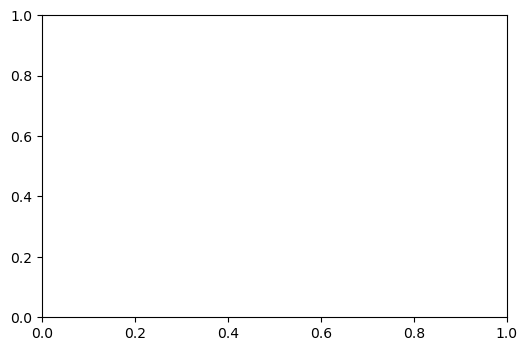

In [17]:
fig = plt.figure(dpi=100)
ax = fig.add_subplot(111)
ax.plot(all_probs[:,0], all_probs[:,1])
ax.set_ylabel('Survival Probability')
ax.set_xlabel('Center Frequency')

In [ ]:
circ_batch[5].draw()